<a href="https://www.kaggle.com/code/fayssalelansari/arabic-tweets-sentiment-analysis?scriptVersionId=116297311" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Diagram of Steps 
In this section we will build a diagram showcasing the different steps used to analyse a set of tweets. 
* For each step of the process we will put all the possible methods in a cluster.
* Between each step there will be an arrow with a label describing how to reach the next step.

We're using `nb_js_diagrammers` with `mermaid` to generate our diagram

In [1]:
%pip install --upgrade nb-js-diagrammers
%load_ext nb_js_diagrammers

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%mermaid_magic -h 1750

flowchart TB
    subgraph DATASET
        tweets[Load Tweets.tsv]
        fetch[fetch Tweets using API]
        tweets --- |or| fetch
    end
    split_decision{Data Already Split \nInto Test And Train?}
    subgraph SPLIT_DATA[Split Data]
        train_test_split[sklearn's train_test_split]
    end
    subgraph NORMALIZE
        tokenize[Tokenize]
        subgraph EXTRACT_ROOT[EXTRACT ROOT]
            lemmetize[Lemmetize]
            stem[Stem]
            lemmetize --- |or| stem
        end
        subgraph PRE_PROCESS[PRE-PROCESS]
            remove_stop_words[Remove Stop Words]
            remove_emojis[Remove/decode Emojis]
            remove_ponctuation[Remove Ponctuation]
            remove_special_characters[Remove Special Characters]   
        end
        remove_stop_words --- |and/or| remove_emojis
        remove_emojis --- |and/or| remove_ponctuation
        remove_ponctuation --- |and/or| remove_special_characters
        
        PRE_PROCESS --> tokenize
        tokenize --> EXTRACT_ROOT
    end
        
    subgraph VECTORIZE
        CountVectorizer --- |or| TfidfTransformer
        TfidfTransformer --- |or| OneHotEncoding
        OneHotEncoding --- |or| Word2Vec 
    end
    
    subgraph TRAIN_CLASSIFIER[TRAIN A CLASSIFIER]
        MultinomialNB[Sklearn's MultinomialNB naive bayes] 
        SGDClassifier[Sklearn's SGDClassifier]
        MultinomialNB --- |or| SGDClassifier
    end
                      
    subgraph PREDICT
        
    end
    
    subgraph ANALYSE
                      
    end
    
    DATASET --> split_decision
    split_decision --> |yes| NORMALIZE
    split_decision --> |no| SPLIT_DATA
    SPLIT_DATA --> NORMALIZE
    NORMALIZE --> VECTORIZE
    VECTORIZE --> TRAIN_CLASSIFIER;
    TRAIN_CLASSIFIER --> PREDICT;
    PREDICT --> ANALYSE;
    ANALYSE --> COMPARE;


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### constants

In [4]:
enc = "UTF-8"

### model files

In [5]:
import enum

class Tag(enum.Enum):
    Neutral = "NEUTRAL"
    Positive = "POSITIVE"
    Negative = "NEGATIVE"
    Not_defined = "NOT_DEFINED"

class Tweet:
    def __init__(self, text, real_tag=Tag.Not_defined, given_tag=Tag.Not_defined):
        self.text = text
        self.real_tag = real_tag
        self.given_tag = given_tag

    def __str__(self):
        txt = self.text
        return txt

    def __repr__(self):
        txt = self.text 
        return txt

## 1. Loading DATASET
### 1.1. Using our own method and model files
    In this section we will use our own definition of a function that will load the files by traversing the folders containing the positive and the negative tweets
    We should compare this method to simply reading the `.tsv` files (which should be faster).

In [6]:
import os
import pathlib

# # current_path = pathlib.Path(__file__).parent.resolve()
# POS_COUNT = 29848
# NEG_COUNT = 28901
# tweets = []

# def import_data():
#     for i in range(POS_COUNT):
#         text = ""
#         with open("/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/" + str(i) + '.txt', encoding=enc) as f:
#             for line in f:
#                 text += line
#         tweets.append(Tweet(text, Tag.Positive))
#     for i in range(NEG_COUNT):
#         text = ""
#         with open("/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/neg/" + str(i) + '.txt', encoding=enc) as f:
#             for line in f:
#                 text += line
#         tweets.append(Tweet(text, Tag.Negative))
        
# import_data()

In [7]:
# print(tweets)

### 1.2. Using `Pandas` to read from `tsv` files directly
    same as the previous step we shall populate a list of tweets[Tweet] with our data.
    After deep thought it is better to use a matrix instead of classes. We shall use pandas to represent our dataset.

In [8]:
column_names = ["sentiment", "content"]
train_tweets_positive = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv", names=column_names)
train_tweets_negative = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv", names=column_names)
test_tweets_positive = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv", names=column_names)
test_tweets_negative = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv", names=column_names)

In [9]:
X_train = pd.concat([train_tweets_positive,train_tweets_negative])
X_test = pd.concat([test_tweets_positive,test_tweets_negative])

from IPython.display import display, HTML
display(X_train)
display(X_test)

,sentiment,content
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,pos,من الخير نفسه 💛
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
...,...,...
22509,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
22510,neg,احسدك على الايم 💔
22511,neg,لأول مرة ما بنكون سوا 💔
22512,neg,بقله ليش يا واطي 🤔


,sentiment,content
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...
1,pos,صباحك خيرات ومسرات 🌸
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...
...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...
5764,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...
5765,neg,انا كنت اكل الصحن بكبره 😐
5766,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...


# 2. Normalize
## 1.1. Preprocessing dataset
Now we need to remove special characters including emoticones since apparently there are many emoticones in arabic tweets, we also need to remove punctuation and `diactrics` which are special characters above letters to determine how they are pronounced, think of them as vowals.

So all that needs to be removed is:
* special characters 
* emoticones
* stop words
* ponctuation
* diactrics

In [10]:
%pip install emojis

Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install pyarabic

Note: you may need to restart the kernel to use updated packages.


In [12]:
from nltk.corpus import stopwords
import emojis

def remove_stop_words(text):
    stop_words = set(stopwords.words("arabic"))
    text = text.split()
    return " ".join([word for word in text if word not in stop_words])

import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decode_emojis(text):
    return emojis.decode(text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)


# in Arabic syllabels are represented by small signs above or below 
# each character, we will remove them 
# and see if they affect our prediction model
import pyarabic.araby as araby

def remove_diactrics(text):
    return araby.strip_diacritics(text)

In [13]:
%pip install tqdm
from tqdm import tqdm

tqdm.pandas(desc="Progress: ")

Note: you may need to restart the kernel to use updated packages.


In [14]:
X_train['preprocessed_content'] = X_train.content.progress_apply(remove_stop_words)
# X_train.content = X_train.preprocessed_content.progress_apply(remove_emojis)
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(decode_emojis)
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(remove_punctuation)
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(remove_diactrics)
display(X_train)

X_test['preprocessed_content'] = X_test.content.progress_apply(remove_stop_words)
# X_test.content = X_test.preprocessed_content.progress_apply(remove_emojis)
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(decode_emojis)
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(remove_punctuation)
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(remove_diactrics)
display(X_test)

Progress: 100%|██████████| 45275/45275 [00:00<00:00, 88524.92it/s]


,sentiment,content,preprocessed_content
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,يتحول نود نقوله دعاء لله تبحثوا فينا قوة إننا ...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,وفي النهاية يبقى معك آحدإلا رأى الجمال روحك أم...
2,pos,من الخير نفسه 💛,الخير نفسه yellow_heart
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,زلزل_الملعب_نصرنا_بيلعب عالي الهمه ترضى بغير ا...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,الشيء الوحيد وصلوا للعالمية المسيار ترى كان...
...,...,...,...
22509,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...,ترى أورانوس يقع مكان القمر blue_heartblue_hea...
22510,neg,احسدك على الايم 💔,احسدك الايم broken_heart
22511,neg,لأول مرة ما بنكون سوا 💔,لأول مرة بنكون سوا broken_heart
22512,neg,بقله ليش يا واطي 🤔,بقله ليش واطي thinking


Progress: 100%|██████████| 11520/11520 [00:00<00:00, 88212.80it/s]


,sentiment,content,preprocessed_content
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...,الهلال_الاهلي فوز هلالي مهم الحمد لله blue_hea...
1,pos,صباحك خيرات ومسرات 🌸,صباحك خيرات ومسرات cherry_blossom
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...,تأمل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...,joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...,رساله صباحيه yellow_heart اللهم اسألك التوفيق...
...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,النوم وانت مكسور ده احساس غبي اللي مش قادر تنا...
5764,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,استشهاد_الامام_كاظم_الغيظ السلام المعذب قعر ال...
5765,neg,انا كنت اكل الصحن بكبره 😐,انا كنت اكل الصحن بكبره neutral_face
5766,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,قولوا ايش تشوفوا ملاحظة التلطف لأنه المود sleepy


## 2.2. Tokenizing dataset
After finishing the pre-processing step it is now time for tokenizing our dataset. There are many ways we achieve this. Starting with a simple `split` with python.

### 2.2.1. Using our own method
We'll try to tokenize our data using python's built-in split function or some other way by making a tokenizing function from scratch, and then applying it to our pre-processed data. The result will be put in a new DataFrame column `tokenized_content`.

In [15]:
def tokenize_split(text):
    return text.split()

### 2.2.2 Using NLTK's word_tokenize
With this tokenizer ponctuation is also considred as a token unlike using split, but that will not change anything since we've already pre-processed that data.

In [16]:
from nltk.tokenize import word_tokenize

In [17]:
X_train['tokenized_content'] = X_train.preprocessed_content.progress_apply(word_tokenize)
display(X_train)

X_test['tokenized_content'] = X_test.preprocessed_content.progress_apply(word_tokenize)
display(X_test)

Progress: 100%|██████████| 45275/45275 [00:05<00:00, 8124.44it/s]


,sentiment,content,preprocessed_content,tokenized_content
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,يتحول نود نقوله دعاء لله تبحثوا فينا قوة إننا ...,"[يتحول, نود, نقوله, دعاء, لله, تبحثوا, فينا, ق..."
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,وفي النهاية يبقى معك آحدإلا رأى الجمال روحك أم...,"[وفي, النهاية, يبقى, معك, آحدإلا, رأى, الجمال,..."
2,pos,من الخير نفسه 💛,الخير نفسه yellow_heart,"[الخير, نفسه, yellow_heart]"
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,زلزل_الملعب_نصرنا_بيلعب عالي الهمه ترضى بغير ا...,"[زلزل_الملعب_نصرنا_بيلعب, عالي, الهمه, ترضى, ب..."
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,الشيء الوحيد وصلوا للعالمية المسيار ترى كان...,"[الشيء, الوحيد, وصلوا, للعالمية, المسيار, ترى,..."
...,...,...,...,...
22509,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...,ترى أورانوس يقع مكان القمر blue_heartblue_hea...,"[ترى, أورانوس, يقع, مكان, القمر, blue_heartblu..."
22510,neg,احسدك على الايم 💔,احسدك الايم broken_heart,"[احسدك, الايم, broken_heart]"
22511,neg,لأول مرة ما بنكون سوا 💔,لأول مرة بنكون سوا broken_heart,"[لأول, مرة, بنكون, سوا, broken_heart]"
22512,neg,بقله ليش يا واطي 🤔,بقله ليش واطي thinking,"[بقله, ليش, واطي, thinking]"


Progress: 100%|██████████| 11520/11520 [00:01<00:00, 7917.03it/s]


,sentiment,content,preprocessed_content,tokenized_content
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...,الهلال_الاهلي فوز هلالي مهم الحمد لله blue_hea...,"[الهلال_الاهلي, فوز, هلالي, مهم, الحمد, لله, b..."
1,pos,صباحك خيرات ومسرات 🌸,صباحك خيرات ومسرات cherry_blossom,"[صباحك, خيرات, ومسرات, cherry_blossom]"
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...,تأمل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ...,"[تأمل, قال, الله, ﷻ, _بواد, زرع, _, dizzydizzy..."
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...,joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...,"[joyjoy, جدعان, الرجاله, اللي, ال, دول, خطر, ت..."
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...,رساله صباحيه yellow_heart اللهم اسألك التوفيق...,"[رساله, صباحيه, yellow_heart, اللهم, اسألك, ال..."
...,...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,النوم وانت مكسور ده احساس غبي اللي مش قادر تنا...,"[النوم, وانت, مكسور, ده, احساس, غبي, اللي, مش,..."
5764,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,استشهاد_الامام_كاظم_الغيظ السلام المعذب قعر ال...,"[استشهاد_الامام_كاظم_الغيظ, السلام, المعذب, قع..."
5765,neg,انا كنت اكل الصحن بكبره 😐,انا كنت اكل الصحن بكبره neutral_face,"[انا, كنت, اكل, الصحن, بكبره, neutral_face]"
5766,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,قولوا ايش تشوفوا ملاحظة التلطف لأنه المود sleepy,"[قولوا, ايش, تشوفوا, ملاحظة, التلطف, لأنه, الم..."


### 2.3. Extracting Root
### 2.3.1. Lemmetize
Now we will try to `Lemmetize` tweets, we believe this is the reason why our prediction model isn't producing better results.
We could try `Farasa` lemmetizer as it has a good reputation of outperforming other lemmetizers. But it uses an API and is not available as an imported library usable directly.

In [18]:
#todo

### 2.3.2. Stemming


So for now we will just stick with ntlk's `ISRIStemmer` and `ARLSTem`

In [19]:
from nltk.stem.isri import ISRIStemmer
stemmer = ISRIStemmer()

from nltk.stem.arlstem import ARLSTem
stemmer = ARLSTem()

def stem(text):
    stemmed = []
    for word in text:
        stemmed.append(stemmer.stem(word))
    return stemmed

def stem_untokenized(text):
    return stemmer.stem(text)

stemming our text into the column `root_extracted_content`, we go from the already tokenized text into producing the stemmer/lemmetized text.

In [20]:
## TESTING WITH TOKENIZED TEXT
# X_train['root_extracted_content'] = X_train.tokenized_content.progress_apply(stem)
# display(X_train)

# X_test['root_extracted_content'] = X_test.tokenized_content.progress_apply(stem)
# display(X_test)

## TESTING WITH UNTOKENIZED TEXT
X_train['root_extracted_content'] = X_train.preprocessed_content.progress_apply(stem_untokenized)
display(X_train)

X_test['root_extracted_content'] = X_test.preprocessed_content.progress_apply(stem_untokenized)
display(X_test)

Progress: 100%|██████████| 45275/45275 [00:00<00:00, 47163.55it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,يتحول نود نقوله دعاء لله تبحثوا فينا قوة إننا ...,"[يتحول, نود, نقوله, دعاء, لله, تبحثوا, فينا, ق...",تحول نود نقوله دعاء لله تبحثوا فينا قوة اننا م...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,وفي النهاية يبقى معك آحدإلا رأى الجمال روحك أم...,"[وفي, النهاية, يبقى, معك, آحدإلا, رأى, الجمال,...",في النهاية يبقي معك احدالا راي الجمال روحك اما...
2,pos,من الخير نفسه 💛,الخير نفسه yellow_heart,"[الخير, نفسه, yellow_heart]",خير نفسه yellow_heart
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,زلزل_الملعب_نصرنا_بيلعب عالي الهمه ترضى بغير ا...,"[زلزل_الملعب_نصرنا_بيلعب, عالي, الهمه, ترضى, ب...",زلزل_الملعب_نصرنا_بيلعب عالي الهمه ترضي بغير ا...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,الشيء الوحيد وصلوا للعالمية المسيار ترى كان...,"[الشيء, الوحيد, وصلوا, للعالمية, المسيار, ترى,...",شيء الوحيد وصلوا للعالمية المسيار تري كانوا...
...,...,...,...,...,...
22509,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...,ترى أورانوس يقع مكان القمر blue_heartblue_hea...,"[ترى, أورانوس, يقع, مكان, القمر, blue_heartblu...",ري اورانوس يقع مكان القمر blue_heartblue_hear...
22510,neg,احسدك على الايم 💔,احسدك الايم broken_heart,"[احسدك, الايم, broken_heart]",حسدك الايم broken_heart
22511,neg,لأول مرة ما بنكون سوا 💔,لأول مرة بنكون سوا broken_heart,"[لأول, مرة, بنكون, سوا, broken_heart]",لاول مرة بنكون سوا broken_heart
22512,neg,بقله ليش يا واطي 🤔,بقله ليش واطي thinking,"[بقله, ليش, واطي, thinking]",بقله ليش واطي thinking


Progress: 100%|██████████| 11520/11520 [00:00<00:00, 48829.43it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...,الهلال_الاهلي فوز هلالي مهم الحمد لله blue_hea...,"[الهلال_الاهلي, فوز, هلالي, مهم, الحمد, لله, b...",هلال_الاهلي فوز هلالي مهم الحمد لله blue_heart...
1,pos,صباحك خيرات ومسرات 🌸,صباحك خيرات ومسرات cherry_blossom,"[صباحك, خيرات, ومسرات, cherry_blossom]",صباحك خيرات ومسرات cherry_blossom
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...,تأمل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ...,"[تأمل, قال, الله, ﷻ, _بواد, زرع, _, dizzydizzy...",امل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ه...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...,joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...,"[joyjoy, جدعان, الرجاله, اللي, ال, دول, خطر, ت...",joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...,رساله صباحيه yellow_heart اللهم اسألك التوفيق...,"[رساله, صباحيه, yellow_heart, اللهم, اسألك, ال...",رساله صباحيه yellow_heart اللهم اسالك التوفيق...
...,...,...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,النوم وانت مكسور ده احساس غبي اللي مش قادر تنا...,"[النوم, وانت, مكسور, ده, احساس, غبي, اللي, مش,...",نوم وانت مكسور ده احساس غبي اللي مش قادر تنام ...
5764,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,استشهاد_الامام_كاظم_الغيظ السلام المعذب قعر ال...,"[استشهاد_الامام_كاظم_الغيظ, السلام, المعذب, قع...",ستشهاد_الامام_كاظم_الغيظ السلام المعذب قعر الس...
5765,neg,انا كنت اكل الصحن بكبره 😐,انا كنت اكل الصحن بكبره neutral_face,"[انا, كنت, اكل, الصحن, بكبره, neutral_face]",ان كنت اكل الصحن بكبره neutral_face
5766,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,قولوا ايش تشوفوا ملاحظة التلطف لأنه المود sleepy,"[قولوا, ايش, تشوفوا, ملاحظة, التلطف, لأنه, الم...",قولوا ايش تشوفوا ملاحظة التلطف لانه المود sleepy


### 3. Vectorizing
### 3.1. Using CountVectorizer
Here we'll convert our collection of tweets to a matrix of token counts, this method takes in many parameters which could make the previous steps unecessary, it could take in a list of `stop words`, a `tokenizer` , `preprocessor` and much more.

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. [source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

A **sparce matrix** is used to store matrices with a lot of zero values in a way to not take a lot of space and make it easier to go through the whole matrix in a short period of time.

**NOTE** WE AREN'T USING THE TOKENIZED TEXT, ONLY THE PRE-PROCESSED DIRECTLY WITH VECOTIRZERS

,00,0012,0032,0041,0044,00am,00clock12,00صtriangular_flag_on_post,0127,013,...,ﻷن,ﻷنو,ﻷﺑﻲ,ﻷﺧﻼق,ﻹﺟﺮﺍﺀ,ﻻتياس,ﻻحظ,ﻻمهلكةسهلة,ﻻيغير,ﻻيمسها
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


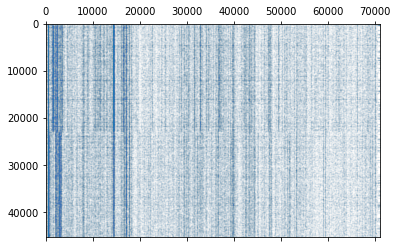

In [21]:
from sklearn.feature_extraction.text import CountVectorizer


count_vect = CountVectorizer()
X_train_cv = count_vect.fit_transform(X_train.root_extracted_content)

import matplotlib.pyplot as plt

plt.spy(X_train_cv, markersize=0.01)

# convert the document term matrix to a dataframe for another visualization
dtm_df = pd.DataFrame(X_train_cv.toarray(), columns=count_vect.get_feature_names_out())
display(dtm_df)

### 3.2. Using TfidfTransformer

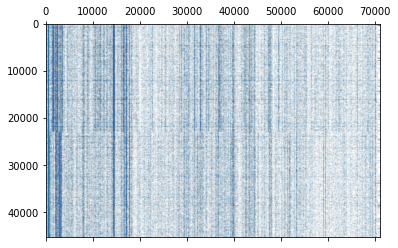

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cv)

plt.spy(X_train_tfidf, markersize=0.01)

## 3.3. Using One Hot Encoding


In one-hot encoding, each unique word in the text data is assigned a unique number, and then each word is represented as a vector (or array) of zeros with a single one at the index of the assigned unique number.


In [23]:
import numpy as np
import pandas as pd

training_positive_tweets = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv", sep='\t',names=['sentiment', 'text'])
training_negative_tweets = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv", sep='\t',names=['sentiment', 'text'])
testing_positive_tweets = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv", sep='\t',names=['sentiment', 'text'])
testing_negative_tweets = pd.read_table("/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv", sep='\t',names=['sentiment', 'text'])


training_positive_tweets = training_positive_tweets.replace(r'\n',' ', regex=True) 
training_negative_tweets = training_negative_tweets.replace(r'\n',' ', regex=True) 
testing_positive_tweets = testing_positive_tweets.replace(r'\n',' ', regex=True) 
testing_negative_tweets = testing_negative_tweets.replace(r'\n',' ', regex=True) 

In [24]:
import gensim
import re
import nltk
import re

#our preprocessing function : it removes any character than is not an arabic character with regex
def preprocess(text):
    text = text.replace("[^\w\s]", "")
    text = re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', ' ', text)
    text = text.split()
    return " ".join(text)

training_tweets = pd.concat([training_positive_tweets, training_negative_tweets])
testing_tweets = pd.concat([testing_positive_tweets, testing_negative_tweets])

X_train_1 = (training_tweets['text'])
y_train_1 = (training_tweets.sentiment)
X_test_1 = (testing_tweets.text)
y_test_1 = (testing_tweets.sentiment)

X_train_1 = X_train_1.progress_apply(lambda x: preprocess(x))
X_test_1 = X_test_1.progress_apply(lambda x: preprocess(x))

all_tokens = [token for tweet in X_train_1 for token in tweet]
vocab, counts = np.unique(all_tokens, return_counts=True)
vocab = vocab[np.argsort(counts)[::-1]]


X_train_1 = X_train_1.progress_apply(preprocess)
X_test_1 = X_test_1.progress_apply(preprocess)

def tweet_to_vector(tokens, vocab):
    vector = np.zeros(len(vocab))
    for token in tokens:
        if token in vocab:
            vector[np.where(vocab == token)[0][0]] = 1
    return vector

X_train_1 = np.vstack([tweet_to_vector(tweet, vocab) for tweet in X_train_1])
X_test_1 = np.vstack([tweet_to_vector(tweet, vocab) for tweet in X_test_1])
y_train_1 = y_train_1.values
y_test_1 = y_test_1.values

Progress: 100%|██████████| 11520/11520 [00:00<00:00, 108208.11it/s]


In [25]:
X_train_1

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model = LogisticRegression(max_iter=1000, solver='saga', tol=1e-3)

model.fit(X_train_1, y_train_1)
y_pred_1 = model.predict(X_test_1)

In [27]:
y_pred_1

array(['pos', 'neg', 'pos', ..., 'pos', 'neg', 'neg'], dtype=object)

In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_1, y_pred_1)
print('Accuracy:', accuracy)

Accuracy: 0.5985243055555556


In [29]:
from sklearn.metrics import classification_report

print('\nClassification report:')
print(classification_report(y_test_1, y_pred_1))


Classification report:
              precision    recall  f1-score   support

         neg       0.59      0.63      0.61      5768
         pos       0.60      0.57      0.59      5752

    accuracy                           0.60     11520
   macro avg       0.60      0.60      0.60     11520
weighted avg       0.60      0.60      0.60     11520



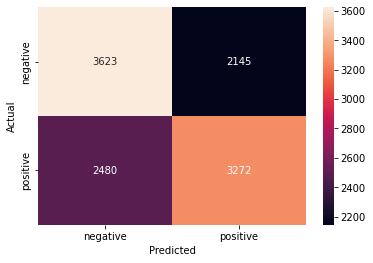

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


conf_mat = confusion_matrix(y_test_1, y_pred_1)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
tp = conf_mat[0][0]
fp = conf_mat[0][1]
tn = conf_mat[1][1]
fn = conf_mat[1][0]

print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)

True Positives:  3623
True Negatives:  3272
False Positives:  2145
False Negatives:  2480


## 3.4. WORD2VEC



In [32]:
from gensim.models import word2vec

# model = word2vec.Word2Vec(X_train.tokenized_content, min_count=1)

## 4. Training a classifier
### 4.1. Using naïve Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, X_train.sentiment)

We will now use our testing dataset (we combine the negative and positivie tweests into one pandas dataframe), then we will call transfrom without calling fit in order to make a prediction.

In [34]:
X_test_cv = count_vect.transform(X_test.root_extracted_content)
X_test_tfidf = tfidf_transformer.transform(X_test_cv)

predicted = clf.predict(X_test_tfidf)

# for tweet, sentiment in zip(X_test.content, predicted):
#     print('%r => %s' % (tweet, sentiment))

# 5. Analyzing
## 5.1. Calculating Accuracy Score
Now we need to get a percentage of the accuracy of our model, we have a list of predicted sentiment and a list of the actual sentiment. Whenever predicted sentiment is different of the actual one we will increment a counter, after going through all the tweets we will divide but the total number of tweets to get a percentage of the wrong predictions, to get the percentage of the right prediction all we need to do is subtract the calculated score from 100%.

In [35]:
wrong_predictions = 0
validity_score = 0
for predicted_sentiment, actual_sentiment in zip(predicted, X_test.sentiment):
    if predicted_sentiment != actual_sentiment:
        wrong_predictions += 1
wrong_predictions_percentage = wrong_predictions / len(X_test.sentiment)
validity_score = 1 - wrong_predictions_percentage
print("validity score: " + str(validity_score*100) + "%")
display(X_test)

validity score: 89.59201388888889%


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content
0,pos,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...,الهلال_الاهلي فوز هلالي مهم الحمد لله blue_hea...,"[الهلال_الاهلي, فوز, هلالي, مهم, الحمد, لله, b...",هلال_الاهلي فوز هلالي مهم الحمد لله blue_heart...
1,pos,صباحك خيرات ومسرات 🌸,صباحك خيرات ومسرات cherry_blossom,"[صباحك, خيرات, ومسرات, cherry_blossom]",صباحك خيرات ومسرات cherry_blossom
2,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...,تأمل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ...,"[تأمل, قال, الله, ﷻ, _بواد, زرع, _, dizzydizzy...",امل قال الله ﷻ _بواد زرع _ dizzydizzy ومع ه...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...,joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...,"[joyjoy, جدعان, الرجاله, اللي, ال, دول, خطر, ت...",joyjoy جدعان الرجاله اللي ال دول خطر تويتر ورب...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...,رساله صباحيه yellow_heart اللهم اسألك التوفيق...,"[رساله, صباحيه, yellow_heart, اللهم, اسألك, ال...",رساله صباحيه yellow_heart اللهم اسالك التوفيق...
...,...,...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...,النوم وانت مكسور ده احساس غبي اللي مش قادر تنا...,"[النوم, وانت, مكسور, ده, احساس, غبي, اللي, مش,...",نوم وانت مكسور ده احساس غبي اللي مش قادر تنام ...
5764,neg,استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...,استشهاد_الامام_كاظم_الغيظ السلام المعذب قعر ال...,"[استشهاد_الامام_كاظم_الغيظ, السلام, المعذب, قع...",ستشهاد_الامام_كاظم_الغيظ السلام المعذب قعر الس...
5765,neg,انا كنت اكل الصحن بكبره 😐,انا كنت اكل الصحن بكبره neutral_face,"[انا, كنت, اكل, الصحن, بكبره, neutral_face]",ان كنت اكل الصحن بكبره neutral_face
5766,neg,قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...,قولوا ايش تشوفوا ملاحظة التلطف لأنه المود sleepy,"[قولوا, ايش, تشوفوا, ملاحظة, التلطف, لأنه, الم...",قولوا ايش تشوفوا ملاحظة التلطف لانه المود sleepy


For the time being we have a validity score of `78.4375%` therefore our prediction model is considred bad, we think it is because we're studying text in `arabic` CountVectorizer is unable to correctly preprocess text and tokenize it. We will try to use another vectorizer to see if the validity increases.

After trying to substitute the emojis with the emotions they convey instead of just deleting them, we got a boost in the precision score of `11%`, now we are getting `89.54%`. We can further try to optimize our model by using an emojis decoder that uses the same language as our data set (Arabic).

### Building a pipeline
To simplify our training and prediction process we will build a new Pipeline

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty=None,
                          alpha=1e-3, random_state=2,
                          max_iter=5, tol=None)),
])

### Using SGDClassifierfrom sklearn.linear_model import SGDClassifier

In [37]:
text_clf.fit(X_train.preprocessed_content, X_train.sentiment)

predicted = text_clf.predict(X_test.preprocessed_content)
np.mean(predicted == X_test.sentiment)

0.9209201388888889

### Parameter tuning using grid search

In [38]:
# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'tfidf__use_idf': (True, False),
#     'clf__alpha': (1e-2, 1e-3),
# }

# gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
# gs_clf = gs_clf.fit(X_train.content[:400], X_train.sentiment[:400])

# 6. Comparing our results with famous analyzers

## 6.1 testing with nltk's own sentimentAnalyzer
Now we'll try to compare our model to NLTK's `sentimentIntensityAnalyzer` to see which one provides better results

In [39]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

## 6.2. Fasttext

FastText is a text classification library developed by Facebook that can be used for sentiment analysis and other natural language processing tasks. It is particularly useful for handling out-of-vocabulary words and rare n-grams. The library is efficient and easy to use, and is based on the skip-gram model of word embeddings.


In [40]:
import fasttext

training_data = pd.concat([training_positive_tweets, training_negative_tweets])
testing_data = pd.concat([testing_positive_tweets, testing_negative_tweets])

#fasttext already has an in-built preprocessing function
#that is why i didn't use a preprocessing function here

with open("training_data.txt", "w", encoding="utf-8") as f:
    for index, row in training_data.iterrows():
        f.write(f"__label__{row['sentiment']} {row['text']}\n")
with open("testing_data.txt", "w", encoding="utf-8") as f:
    for index, row in testing_data.iterrows():
        f.write(f"__label__{row['sentiment']} {row['text']}\n")


classifier = fasttext.train_supervised(input="training_data.txt", lr=0.1, epoch=25, wordNgrams=2, loss="hs")

result = classifier.test("training_data.txt")
print(f"Training precision: {result[1]}")

result = classifier.test("testing_data.txt")
print(f"Testing precision: {result[1]}")
print(f"Testing recall: {result[2]}")

Read 0M words
Number of words:  83730
Number of labels: 2
Progress: 

Training precision: 0.9942573163997791
Testing precision: 0.9557291666666666
Testing recall: 0.9557291666666666


Progress: 100.0% words/sec/thread: 1358347 lr:  0.000000 avg.loss:  0.031723 ETA:   0h 0m 0s


In [41]:
y_pred = [classifier.predict(x)[0][0] for x in testing_data["text"]]
y_true = testing_data["sentiment"]

for i in range(len(y_pred)):
    if y_pred[i] == '__label__pos':
        y_pred[i] = 'pos'
    else:
        y_pred[i] = 'neg'
        
print('\nClassification report:')
print(classification_report(y_true, y_pred))


Classification report:
              precision    recall  f1-score   support

         neg       0.95      0.96      0.96      5768
         pos       0.96      0.95      0.96      5752

    accuracy                           0.96     11520
   macro avg       0.96      0.96      0.96     11520
weighted avg       0.96      0.96      0.96     11520



### 6.2.2. Confusion Matrix for `fasttext`

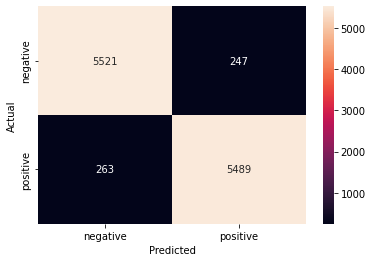

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

    
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



The main benefit of using FastText is that it can classify texts and words with high accuracy and precision, even when it hasn't seen that specific word before.

This is because it uses character-level embeddings, which means that it can understand the meaning of a new word by analyzing the characters that make it up.

This is particularly useful when dealing with out-of-vocabulary words that are commonly seen in social media, like emojis and hashtags.


# 7. word embeddings example
an example using word embeddings with some features (chosen by us).

In [43]:
model = fasttext.train_unsupervised('training_data.txt', model='skipgram')

Read 0M words
Number of words:  15053
Number of labels: 2
Progress: 100.0% words/sec/thread:   79499 lr:  0.000000 avg.loss:  1.694734 ETA:   0h 0m 0s


In [44]:
#print(model.words) 
word_vector1 = model.get_word_vector('البحر') # sea
word_vector2 = model.get_word_vector('الأرض') # earth
word_vector3 = model.get_word_vector('السماء') # sky

word_vector4 = model.get_word_vector('قط') # cat
word_vector5 = model.get_word_vector('كلب') # dog

word_vector6 = model.get_word_vector('تونس') # tunisia
word_vector7 = model.get_word_vector('مغرب') # morocco
word_vector8 = model.get_word_vector('فرنسا') # france

#example of the vector
print(word_vector1)

[ 0.90680474 -0.10217115  0.26276582  0.18554889 -0.4365705   0.44811085
  0.2110124   0.18410313 -0.04882779 -0.00418971  0.39746416  0.5026316
  0.49728593  0.53448945 -0.2933202  -0.16136548 -0.37330657 -0.03625901
  0.1452605   0.15314254  0.43731853  0.25603205 -0.24790043 -0.2812897
 -0.7431957  -0.16318569  0.9598047  -0.30133304 -0.3503181   0.37059313
  0.02927801  0.52801067 -0.5196308   0.06245535  0.14523736 -0.08181555
 -0.13167755 -0.48596504  0.27638283 -0.89085925  0.18641225  0.0575847
 -0.09798937 -0.0847691   0.42097506  0.394446   -0.19754937 -0.37966684
 -0.11634026  0.365753   -0.41187808  0.47746626 -0.35977     0.04824208
  0.6064006  -0.00779075  0.14005889 -0.09773418  0.05927977 -0.05948376
  0.19950394 -0.29912695 -0.27335706  0.29996696 -0.14555632 -0.3428142
 -0.48927623  0.21955805 -0.3386342   0.26464093 -0.01145412  1.0682764
  0.3029054  -0.44045004  0.10868186  0.4644961   0.62537986 -0.09126589
 -0.03743721 -0.7048446   0.2899318   0.22508645 -0.2228

In [45]:
#suppressing the future warnings for better visualisation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


distance between sky, earth and sea


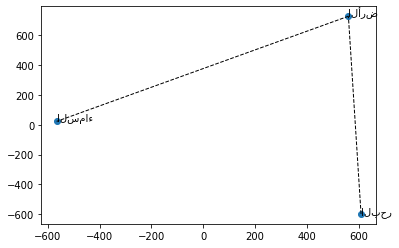

In [46]:
vectors1 = np.array([word_vector1, word_vector2, word_vector3])
vectors2 = np.array([word_vector4, word_vector5])
vectors3 = np.array([word_vector6, word_vector7, word_vector8])

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#first representation for the distance between sky, earth and sea

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
vectors_2d = tsne.fit_transform(vectors1)

print()
print("\033[1mdistance between sky, earth and sea\033[0m")

plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
labels = ['البحر', 'الأرض', 'السماء']

for i in range(len(vectors_2d)-1):
    plt.plot(vectors_2d[i:i+2, 0], vectors_2d[i:i+2, 1], 'k--', linewidth=1)

for label, x, y in zip(labels, vectors_2d[:, 0], vectors_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


distance between cat and dog


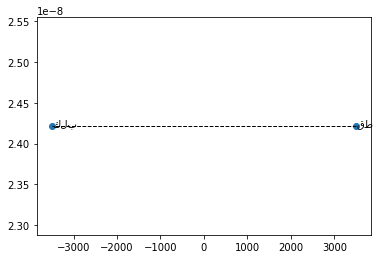

In [47]:
#second representation for the distance between cat and dog

vectors_2d = tsne.fit_transform(vectors2)
print()
print("\033[1mdistance between cat and dog\033[0m")
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

labels = ['قط', 'كلب']
for i in range(len(vectors_2d)-1):
    plt.plot(vectors_2d[i:i+2, 0], vectors_2d[i:i+2, 1], 'k--', linewidth=1)

for label, x, y in zip(labels, vectors_2d[:, 0], vectors_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


distance between tunisia, morocco and france


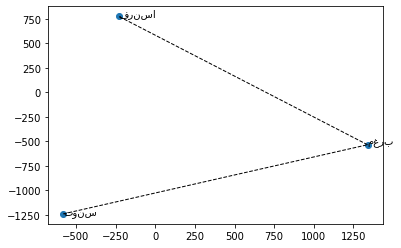

In [48]:
#third representation for the distance between tunisia, morocco and france

vectors_2d = tsne.fit_transform(vectors3)
print()
print("\033[1mdistance between tunisia, morocco and france\033[0m")
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

labels = ['تونس', 'مغرب', 'فرنسا']
for i in range(len(vectors_2d)-1):
    plt.plot(vectors_2d[i:i+2, 0], vectors_2d[i:i+2, 1], 'k--', linewidth=1)

for label, x, y in zip(labels, vectors_2d[:, 0], vectors_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

In [49]:
model.get_nearest_neighbors('المدرسة', k=5)
# nearest word to "school" in our data sample
# first word is another pronounciation of "school" 
# or words like "school benches", "school coach" etc..

[(0.9789462089538574, 'المدرسه'),
 (0.91932612657547, 'المدرب'),
 (0.9079432487487793, 'المدرج'),
 (0.8996990323066711, 'المدرجات'),
 (0.8972643613815308, 'المدح')]

We are using a basic training data file which is compiled from many tweets from different dialects which spell words differently or where words have different meanings depending on the dialect.

This is why it might be harder to see the connection between the vectors, however we can see that some words have a decent vectorial representation and distance between them.


## 7.2. Using embedding for the sentiment analyser

We are going to train a fasttext model on the training data and then create sentence embeddings of the testing data by averaging the word embeddings in each sentence. Then, we are using logistic Regression classifier to classify the sentiment.


In [50]:
import fasttext
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

training_data = pd.concat([training_positive_tweets, training_negative_tweets])
testing_data = pd.concat([testing_positive_tweets, testing_negative_tweets])

# Extract embeddings for the testing data
X_test = np.array([model.get_sentence_vector(text) for text in testing_data["text"]])
y_test = testing_data["sentiment"]

X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
y_val_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
print("Validation accuracy: {:.2f}%".format(accuracy * 100))

Validation accuracy: 77.52%


In [51]:
print('\nClassification report:')
print(classification_report(y_val, y_val_pred))


Classification report:
              precision    recall  f1-score   support

         neg       0.76      0.79      0.78      1130
         pos       0.79      0.76      0.78      1174

    accuracy                           0.78      2304
   macro avg       0.78      0.78      0.78      2304
weighted avg       0.78      0.78      0.78      2304



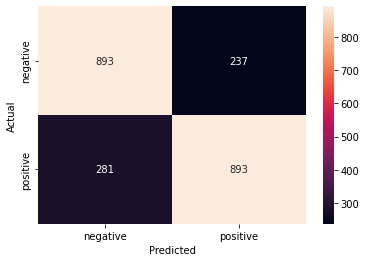

In [52]:
conf_mat = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
tp = conf_mat[0][0]
fp = conf_mat[0][1]
tn = conf_mat[1][1]
fn = conf_mat[1][0]

print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)

True Positives:  893
True Negatives:  893
False Positives:  237
False Negatives:  281


# TODO LIST
* [X] PREPROCESS DATA
* [X] STEM ARABIC WORDS
* [x] ADD DEFINITIONS FOR COMMON KEYWORDS
* [x] DEFINE THE EXACT STEPS USED IN THE PIPELINE (MAKE A DIAGRAM)
* [ ] DEFINE FOR EACH STEP THE LIST OF POSSIBLE METHODS TO USE
* [ ] DEFINE FOR EACH METHOD A SMALL LIST OF POSSIBLE CONFIGURATION FOR THE PARAMETERS TO USE
* [ ] MAKE PIPELINE
* [ ] EMBEDDINGS
* [ ] CONFUSION MATRIX

1. How to split data into `test` and `train` data-sets from one initial data-set?
2. Emojis convey emotions so instead of deleting them we should substitute each emoji with the emotion it represents
3. when applying different steps of the Pipeline, instead of putting new data in a new variable or data frame just add a `new column` with a representive tag. To compare and keep track of each step.

# Ideas to implement
1. webapp:
    * make a front end connected to a trained model or give the user the ability to train his own model.
    * in the webpage there will be a way to fetch a predetermined number of tweets using a keyword or a hashtag (should be in arabic). 
2. Since for the same step there could be different methods and for each method different methods add an easier way to change the method and the parameters, could be modified in the web page also.
3. show graphs for different stats of the chosen models and methods
4. a way to run all possible (or a lot) methods and parameters and order them by decreasing order of validity
5. add progress bar when creating and modifying dataframes.

# Definitions of Common Terms
**Normalizing**: Also called text cleansing, is the process of preprocessing text data to be understood and used by Natural Language Processors and other text analytics software. It includes many other substeps such as `tokenizing`, `case conversion`, `correcting spelling`, `removing stop words`, `stemming` and `lemmatization`.

**Tokenization**: It is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens. Usually we split a text document by word to obtain a token for each individual word in a list of tokens.

**Stop words**: A list of the most common words in a language

**Vectorization**: The process of writing tokens of text data in the form of vectors, since computer programs are only able to understand numbers it is important to vectorize text data in order to process it. Also called `Feature extraction`; There are many feature-extraction methods the most famous being `bag of words based frequency features`.

**Feature Matrix**: In this matrix each row represents a document (here tweet) and each column represents a feature (processed token). It is used by ML and statistical models to provide predictions.

**Stemming**: Consists of extracting only the smallest uncompressable part of a word not containing any suffixes or prefixes or any other inflections. Then converting it to the root or the source of the meaning of that word.

**lemmatization**: Similar to `Stemming` is the same process of removing inflections from a feature (token) but without converting it to its origin of meaning. It is less representative for making prediction since more words can have the same stem than the the words having the same lemma.

**Bag of Words Model**: One of the most popular yet simple Feature Extraction methods, for each document we build a set of words without any regard of the order of presence (hence the name bag of words). But keeping count for each word.

**Confusion Matrix**: lso known as an `error matrix`, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a `matching matrix`). Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in the literature. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another).


# References
...
